<a href="https://colab.research.google.com/github/LLBockenhoff/PRA3024/blob/main/ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [10]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [11]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


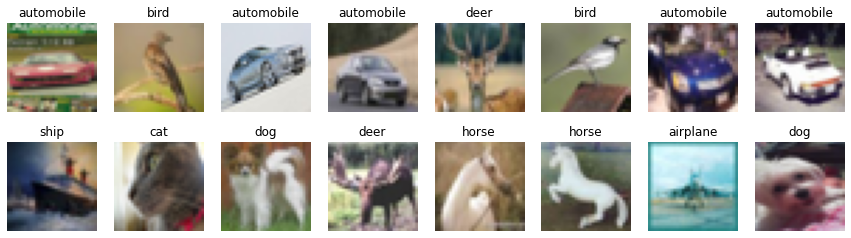

In [12]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [13]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [14]:
# import necessary building blocks
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

My first model is inspired by an InceptionNet. The idea is to stack inception blocks, which take responsibility of the feature selection before handing the filters into a dense classifier. Each inception block splits up the data into 3 path which have different "field of view" expressed by different kernel sizes. Then the path rejoin before going into the next block. In each layer the image is downsampled, allowing for a proper hirachy of features throughout the network. 

In [27]:
def make_model():
  #Number of featurmaps/filters per layer
  features = [32, 64, 128]
  red_factor = 2
  #setting the dropout for the network
  dropout = 0.25
  #setting up the batchNorm hyper parameters
  eps = 1.1e-5 
  #growth factor in the concat layer 
  growth = 2

  #setting the input shape  
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  #First Conv layer is required before going into the inceptionNet blocks
  #x = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), padding="same")( inputs )
  x = inputs
  
  #This loop creates the inception blocks
  for i in range(len(features)):
      num_features = features[i]
        
      # BatchNorm like the name suggests normalises the classes inside each batch, which does allow for more smoth learning, tho always 
      #introduces a certain level of noise to the network 
      one = tf.keras.layers.BatchNormalization(epsilon=eps)(x)
        #This 1 by 1 Convolution is called a bottle neck layer, which controls the feature channels throughout the network 
      one = tf.keras.layers.Conv2D(num_features, kernel_size=(1, 1), activation='elu', padding="same")(one)
        #Maxpooling downsamples the image
      one = tf.keras.layers.MaxPooling2D(pool_size=(red_factor, red_factor))(one)
      one_out = tf.keras.layers.Dropout(rate=dropout)(one)
    
      three = tf.keras.layers.BatchNormalization(epsilon=eps)(x)
      three = tf.keras.layers.Conv2D(num_features, kernel_size=(1, 1), activation='elu', padding="same")(three)
      three = tf.keras.layers.Conv2D(num_features, kernel_size=(3, 3),  strides=red_factor, activation='elu', padding="same")(three)
      three_out = tf.keras.layers.Dropout(rate=dropout)(three)
        
      five = tf.keras.layers.BatchNormalization(epsilon=eps)(x)
      five = tf.keras.layers.Conv2D(num_features, kernel_size=(1, 1), activation='elu', padding="same")(five)
      five = tf.keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='elu', padding="same")(five)
      # strides of 2 allows for a trainable Maxpooling layer, which can increase accuracy with the danger of overfitting 
      five = tf.keras.layers.Conv2D(num_features, kernel_size=(3, 3), strides=red_factor, activation='elu', padding="same")(five)
      five_out = tf.keras.layers.Dropout(rate=dropout)(five)                                          

        #This concatenate layer collects all features featuremaps and combines them in one tensor     
      col = tf.keras.layers.concatenate([one_out, three_out, five_out])  
      red = tf.keras.layers.Conv2D(growth*num_features, kernel_size=(1, 1), activation='elu', padding="same")(col)                                            
      x = red                         

  #reverse bottleneck layer increases the channels
  x = tf.keras.layers.Conv2D(2048, kernel_size=(1, 1), activation='elu', padding="same")(red)                                                     
  #GlobalAveragePooling allows to collapse the featuretensor into a vector, which the fits with the dense classifier
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)

  #Densly connected classifier
  x = tf.keras.layers.Dense(512) (x)
  x = tf.keras.layers.Activation('elu')(x)
  
  x = tf.keras.layers.Dropout(rate=dropout)(x)

  x = tf.keras.layers.Dense(256) (x)
  x = tf.keras.layers.Activation('elu')(x)
    
  x = tf.keras.layers.Dropout(rate=dropout)(x)

  x = tf.keras.layers.Dense(10)(x)
  outputs = tf.keras.layers.Activation('softmax')(x)
    
  model = tf.keras.models.Model(inputs, outputs)
  return model

This model is a classical Sequential CNN network with a dense classifier. Maxpooling is replaced by stride2 conv layers. An interesting nuance is the flatten layer with replaces the GlobalAveragePooling. Here instead of collapsing the features into a vector, the 4x4 featuremaps are flattened into a 4*4*128 character long vector, which then is given to the classifier. This only works for small images, for the object is always in the center and thereby this method does not terribly overfits on the position of the object. 

In [26]:
def make_other_model():
  model = Sequential()

  model.add(Conv2D(32, (3,3), padding='same', activation="elu", input_shape=x_train.shape[1:]))
  model.add(BatchNormalization()) 
  model.add(Conv2D(32, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', strides=2, activation="elu"))
  #model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', strides=2, activation="elu"))
  #model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', activation="elu"))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', strides=2, activation="elu"))
  #model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(128, activation='elu'))
  model.add(Dense(64, activation='elu'))
  model.add(Dropout(0.1))
  model.add(Dense(10, activation='softmax'))
    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network. 
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ### 

    # Ensure normalized probabilities over the 10 classes
    #model.add(Activation("softmax")) 

  return model

In [21]:
#learning rate scheduler decreases the lr in later epoch which allows more staple learning in later stages
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.04)

def scheduler_2(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.07)

In [29]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 3e-3  # initial learning rate
BATCH_SIZE = 128
EPOCHS = 100

#early stoppig prevents the model to overfit  
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=17)


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)
# dataaugmentation creates additional training data by making small changes to the images
datagen = ImageDataGenerator(
    #allows the images to be rotated
    rotation_range=15,
    height_shift_range=0.15,
    width_shift_range=0.15,
    vertical_flip=True,
    zoom_range=0.1,
    )
#applies the potential changes to the data
datagen.fit(x_train)

# fit model
learning_rate= tf.keras.callbacks.LearningRateScheduler(scheduler)

#fit generator extends the fit function with the dataaugmentation
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
    epochs=EPOCHS,
    # the two callbacks active are the lr scheduler and the early stopping
    callbacks=[callback, learning_rate],
    validation_data=(x_val, y_val),
    )

# save weights to file to avoid re-training
model.save_weights("weights.h5")




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
313/313 [==============================] - 27s 80ms/step - loss: 2.4224 - accuracy: 0.2417 - val_loss: 2.6915 - val_accuracy: 0.2606
Epoch 2/100
313/313 [==============================] - 25s 79ms/step - loss: 1.6707 - accuracy: 0.3811 - val_loss: 1.5155 - val_accuracy: 0.4627
Epoch 3/100
313/313 [==============================] - 25s 78ms/step - loss: 1.5134 - accuracy: 0.4443 - val_loss: 1.4626 - val_accuracy: 0.4913
Epoch 4/100
313/313 [==============================] - 25s 79ms/step - loss: 1.4196 - accuracy: 0.4841 - val_loss: 1.3659 - val_accuracy: 0.5321
Epoch 5/100
313/313 [==============================] - 25s 79ms/step - loss: 1.3226 - accuracy: 0.5221 - val_loss: 1.2727 - val_accuracy: 0.5539
Epoch 6/100
313/313 [==============================] - 25s 78ms/step - loss: 1.2605 - accuracy: 0.5469 - val_loss: 1.1358 - val_accuracy: 0.6031
Epoch 7/100
313/313 [==============================] - 24s 78ms/step - loss: 1.1968 - accuracy: 0.5730 - val_loss: 1.1112 - val_ac

In [23]:
model_2 = make_other_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_2.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

learning_rate_2= tf.keras.callbacks.LearningRateScheduler(scheduler_2)
# fit model

history_2 = model_2.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
    epochs=EPOCHS,
    callbacks=[callback, learning_rate_2],
    validation_data=(x_val, y_val),
    )

# save weights to file to avoid re-training
model_2.save_weights("weights2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
313/313 [==============================] - 24s 72ms/step - loss: 2.0509 - accuracy: 0.2796 - val_loss: 2.5311 - val_accuracy: 0.2301
Epoch 2/100
313/313 [==============================] - 22s 72ms/step - loss: 1.6181 - accuracy: 0.4096 - val_loss: 1.6129 - val_accuracy: 0.4290
Epoch 3/100
313/313 [==============================] - 23s 72ms/step - loss: 1.4953 - accuracy: 0.4537 - val_loss: 1.3263 - val_accuracy: 0.5158
Epoch 4/100
313/313 [==============================] - 22s 71ms/step - loss: 1.3598 - accuracy: 0.5083 - val_loss: 1.1982 - val_accuracy: 0.5642
Epoch 5/100
313/313 [==============================] - 23s 72ms/step - loss: 1.2601 - accuracy: 0.5436 - val_loss: 1.1222 - val_accuracy: 0.5975
Epoch 6/100
313/313 [==============================] - 22s 71ms/step - loss: 1.1673 - accuracy: 0.5815 - val_loss: 1.0157 - val_accuracy: 0.6321
Epoch 7/100
313/313 [==============================] - 22s 71ms/step - loss: 1.1059 - accuracy: 0.6043 - val_loss: 1.0593 - val_ac

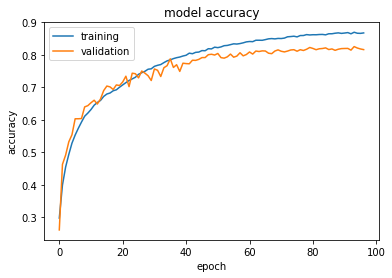

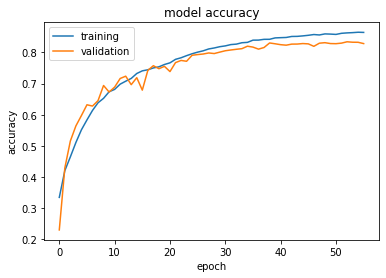

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

We see that both network have a rather smooth learning rate once the learning rate scheduler kicks in and get stopped at the right moment when the overfitting starts to take over.

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
______________________________________________________________________________________________

In [32]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")
model_2.load_weights("weights2.h5")

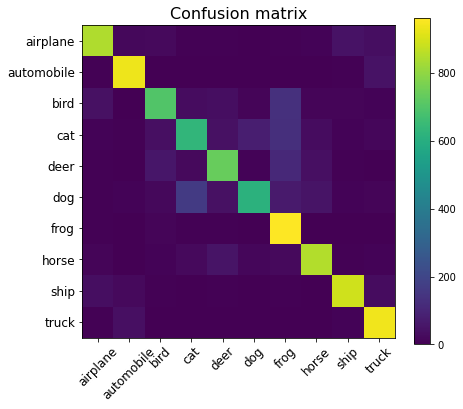

Test accuracy model 1: 0.8119


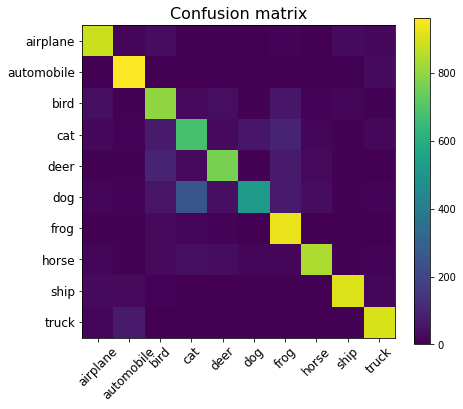

Test accuracy model 2: 0.8191


In [33]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy model 1:", accuracy_score(y_test_index, y_pred_test_classes))

# make test predictions
y_pred_test_2 = model_2.predict(x_test)
y_pred_test_classes_2 = np.argmax(y_pred_test_2, axis=1)
y_pred_test_max_probas_2 = np.max(y_pred_test_2, axis=1)
y_test_index_2 = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index_2, y_pred_test_classes_2))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy model 2:", accuracy_score(y_test_index_2, y_pred_test_classes_2))

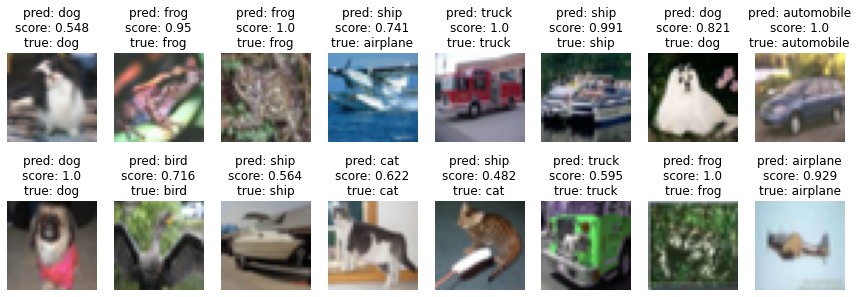

In [34]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

We can see that both models are performing rather well and reach accuracies beyond the 80%. WHen looking at the images and confusion matricies, we see why some images are missclassified rather often. For one, a blue background always gets classified as a ship while a very bright background gets classified as an airplane. We might have not reached human level accuracy yet (95% something considering some of the harder images), however, this already is a rather good result for this short project. 

Comparing the two networks, the sequential one does seem way easier, while performing even better than the inception one. This can be explained by considering the small size of the images and the flattening approach that was used for the sequential network. While Sequential network will struggle with larger images and more diverse classes, the inceptionNet will scale up better, because of its more efficient structure. 

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


